# SETUP

In [ ]:
%%capture
!pip install -U bitsandbytes
!pip install accelerate
!pip install transformers datasets wget umap-learn
!pip install info-nce-pytorch

In [1]:
import math
import os
import json
import torch
import re
import requests
import torch.nn as nn
from PIL import Image
import wget
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import zipfile
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import requests
from transformers import LlavaProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
import time
import pandas as pd

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16    
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!wget https://raw.githubusercontent.com/MaatVO/Fine-Tuning-Multilingual-MiniLM-L12-H384/main/predictions.csv -O predictions.csv
!wget https://raw.githubusercontent.com/MaatVO/Fine-Tuning-Multilingual-MiniLM-L12-H384/refs/heads/main/ground_truth.csv

In [ ]:
pred_df = pd.read_csv("/kaggle/working/predictions.csv", sep=',')
ground_truth = pd.read_csv('/kaggle/working/ground_truth.csv', sep=',')
ground_truth

# Initializing dataset

In [ ]:
limit = 2500

# List to store the results
results = []
image_features, image_features_proj, text_features, image_inputs, text_inputs = [], [], [], [], []
final_embeddings = []

# define paths to the directories:
data_path = '/kaggle/input/imaging/numerosity_naming_images/'
image_list = os.listdir('/kaggle/input/imaging/numerosity_naming_images/')

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing {category} and ending with .png
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [data_path+f for f in image_list if category in f and f.endswith('.png')]
targets = [f.split('_')[0] + ' ' + 'apples' for f in image_list if f.endswith('.png')]
len(targets)

# Training

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        caption = f'There are {self.targets[idx]} things in this image'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]


# Function to create train/test datasets
def create_datasets(image_paths, targets, test_size=0.2, random_seed=4):
    """
    Splits the dataset into training and testing sets.
    
    Args:
        image_paths (list): List of paths to images.
        targets (list): List of target labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        train_dataset (CustomDataset): Training dataset.
        test_dataset (CustomDataset): Testing dataset.
    """
    # Split into training and testing sets
    train_paths, test_paths, train_targets, test_targets = train_test_split(
        image_paths, targets, test_size=test_size, random_state=random_seed, shuffle=True, stratify=targets
    )
    
    # Create dataset instances
    train_dataset = CustomDataset(train_paths, train_targets, processor)
    test_dataset = CustomDataset(test_paths, test_targets, processor)
    
    return train_dataset, test_dataset


# Paths and targets
base_path = "/kaggle/input/imaging/numerosity_naming_images/"
image_list = os.listdir(base_path)

# Corrected list comprehensions
categories_train = ['butterflies', 'peoples', 'apples']
categories_eval = ['dots','fastcards']
image_paths = [
    os.path.join(base_path, file_name) 
    for file_name in image_list 
    if any(category in file_name for category in categories) and file_name.endswith('.png')
]

targets = [
    f.split('_')[0] + ' things' 
    for f in image_list 
    if any(category in f for category in categories) and f.endswith('.png')
]



# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_paths, targets, test_size=0.1)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)



# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device).train()

# Training setup

loss_fn = InfoNCE(negative_mode="paired", temperature=1)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        #print(all_targets[most_similar_idx])
        #print(ta)
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

## TRAIN ON THREE CATEGORIES TEST ON OTHER TWO

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        caption = f'There are {self.targets[idx]} things in this image'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]


# Function to create train/test datasets
def create_datasets(image_list, random_seed=4):
    """
    Splits the dataset into training and testing sets.
    
    Args:
        image_paths (list): List of paths to images.
        targets (list): List of target labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        train_dataset (CustomDataset): Training dataset.
        test_dataset (CustomDataset): Testing dataset.
    """
    # Split into training and testing sets
    
    # Updated categories
    categories_train = ['butterflies', 'peoples', 'apples']  # Test categories become train
    categories_test = ['dots', 'fastcards']  # Train categories become eval
    
    train_paths = [
        os.path.join(base_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_train) and file_name.endswith('.png')
    ]
    
    train_targets = [
        'There are' + f.split('_')[0]+ ' things' 
        for f in image_list 
        if any(category in f for category in categories_train) and f.endswith('.png')
    ]

    test_paths = [
        os.path.join(base_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_test) and file_name.endswith('.png')
    ]
    
    test_targets = [
        'There are' + f.split('_')[0]+ ' things'  
        for f in image_list 
        if any(category in f for category in categories_test) and f.endswith('.png')
    ]
    # Create dataset instances
    train_dataset = CustomDataset(train_paths, train_targets, processor)
    test_dataset = CustomDataset(test_paths, test_targets, processor)
    
    return train_dataset, test_dataset


# Paths and targets
base_path = "/kaggle/input/imaging/numerosity_naming_images/"
image_list = os.listdir(base_path)

# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_list)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device).train()

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=1)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 15
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

In [ ]:
# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        #print(all_targets[most_similar_idx])
        #print(ta)
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

OLD

# CLIP Load and Prepare SINGLE CATEGORY

In [ ]:
limit = 2500

# List to store the results
results = []
image_features, image_features_proj, text_features, image_inputs, text_inputs = [], [], [], [], []
final_embeddings = []

# define paths to the directories:
data_path = '/kaggle/input/imaging/numerosity_naming_images/'
image_list = os.listdir('/kaggle/input/imaging/numerosity_naming_images/')

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing apples
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [f for f in image_list if f.endswith('.png')]

# Use a dictionary to store unique prefixes (e.g., '1_apples', '2_apples') with their full filenames
unique_apple_files = {}
for file in apple_files:
    prefix = '_'.join(file.split('_')[:2])  # Extract '1_apples', '2_apples'
    if prefix not in unique_apple_files:
        unique_apple_files[prefix] = file  # Store the full filename
    if len(unique_apple_files) == 20:  # Stop when we have 20 unique files
        break

# Get the full filenames from the dictionary
final_apple_files = list(unique_apple_files.values())

print(final_apple_files)

USE THIS pre-training

In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Updated categories
categories_test = ['dots', 'fastcards']  # Test categories become train
categories_train = ['butterflies', 'peoples', 'apples']  # Train categories become eval

base_path = "/kaggle/input/imaging/numerosity_naming_images/"
image_list = os.listdir(base_path)

train_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_train) and file_name.endswith('.png')
]

train_targets = [
    'There are'+ f.split('_')[0]+' things'  
    for f in image_list 
    if any(category in f for category in categories_train) and f.endswith('.png')
]

test_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_test) and file_name.endswith('.png') #and file_name.split('_')[0] == '1'
]

test_target = [
    'There are'+ f.split('_')[0] +' things' 
    for f in image_list 
    if any(category in f for category in categories_test) and f.endswith('.png')
]



# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []


# Process images and compute features
for filename in tqdm(apple_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)

    datapath = '/kaggle/input/imaging/numerosity_naming_images/'
    
    # Open and preprocess the image
    im = Image.open(datapath + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(apple_files):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(apple_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Calculate the means of the embeddings
mean_image_embedding = np.mean(image_features, axis=0)  # Mean of all image embeddings
mean_text_embedding = np.mean(text_features, axis=0)    # Mean of all text embeddings

# Normalize the means
mean_image_embedding = mean_image_embedding / np.linalg.norm(mean_image_embedding)
mean_text_embedding = mean_text_embedding / np.linalg.norm(mean_text_embedding)

# Compute the gap (∆gap)
delta_gap = np.linalg.norm(mean_image_embedding - mean_text_embedding)

# Print the metric
#print(f"\nMean Image Embedding: {mean_image_embedding}")
#print(f"Mean Text Embedding: {mean_text_embedding}")
print(f"Delta Gap (∆gap): {delta_gap:.4f}")



In [ ]:
# Calculate the means of the embeddings
mean_image_embedding = np.mean(image_features, axis=0)  # Mean of all image embeddings
mean_text_embedding = np.mean(text_features, axis=0)    # Mean of all text embeddings

# Normalize the means
mean_image_embedding = mean_image_embedding / np.linalg.norm(mean_image_embedding)
mean_text_embedding = mean_text_embedding / np.linalg.norm(mean_text_embedding)

# Compute the gap (∆gap)
delta_gap = np.linalg.norm(mean_image_embedding - mean_text_embedding)

# Print the metric
#print(f"\nMean Image Embedding: {mean_image_embedding}")
#print(f"Mean Text Embedding: {mean_text_embedding}")
print(f"Delta Gap (∆gap): {delta_gap:.4f}")


In [ ]:
# Filter misclassified predictions
misclassified_df = results_df[~results_df["Correct"]]

# Group by True Target and count misclassifications
misclassified_distribution = misclassified_df.groupby("True Target").size().sort_values(ascending=False)

print("\nMisclassified Predictions Distribution (Sorted):")
print(misclassified_distribution)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=misclassified_distribution.values,
    y=misclassified_distribution.index,
    palette="Reds_r",
)
plt.title("Distribution of Misclassified Predictions (Sorted by Count)")
plt.xlabel("Number of Misclassified Predictions")
plt.ylabel("True Target")
plt.show()

# Group by True Target and Predicted Target
misclassified_details = (
    misclassified_df.groupby(["True Target", "Predicted Target"])
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)

print("\nDetailed Misclassification Breakdown:")
print(misclassified_details)

# Optional: Save the detailed breakdown to a CSV file for further analysis
misclassified_details.to_csv("misclassified_details.csv", sep=";", decimal=",", index=False)


use this after training

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming `apple_files` and `category` are already defined as in your code

# Load the model and processor
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval().to(device)

# List of text inputs (numbers from 1 to 20)
text_inputs_list = [str(i) for i in range(1, 21)]

# Prepare lists to store features
image_features, text_features = [], []

# Process images and compute features
for filename in tqdm(apple_files):
    # Set target and caption (ground truth is just the number of items in the image)
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'{target} things'  # Text input is just the number as a string
    
    datapath = '/kaggle/input/imaging/numerosity_naming_images/'
    
    # Open and preprocess the image
    im = Image.open(datapath + filename)
    inputs = processor(text=text_inputs_list, images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        image_feat = outputs['image_features']
        
        # Select the correct text embedding based on the target index (0-based index)
        correct_text_feat =outputs['text_features']  # Subtract 1 for 0-based indexing

        # Normalize features
        image_feat /= image_feat.norm(dim=-1, keepdim=True)
        correct_text_feat /= correct_text_feat.norm(dim=-1, keepdim=True)
    
    # Convert to numpy and append to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(correct_text_feat.cpu().numpy())
    
# Convert lists to tensors
image_features = torch.tensor(np.array(image_features))
text_features = torch.tensor(np.array(text_features))

print(image_features.shape)  # Should output: torch.Size([500, 512])
print(text_features.shape)    # Should output: torch.Size([500, 512])




this not

In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# List of image files and targets
apple_files = [f for f in image_list if category in f and f.endswith('.png')]
targets = [f.split('_')[0] + ' ' + 'apples' for f in image_list if category in f and f.endswith('.png')]

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#model.eval().to(device)

# Prepare lists to store features
image_features, text_features = [], []

# Process images and compute features
for filename in tqdm(apple_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'{target} things'  # Text input is just the number as a string

    datapath = '/kaggle/input/imaging/numerosity_naming_images/'
    
    # Open and preprocess the image
    im = Image.open(datapath + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get text features using model's get_text_features method
        text_feat = outputs['text_features']
        # Normalize features
        image_feat = outputs['image_features']
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features).squeeze(1)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)    # Shape: (500, 512)

print(image_features.shape)
print(text_features.shape)

# Compute similarity matrix (cosine similarity between each image and its corresponding text)
similarity = cosine_similarity(image_features, text_features)  # Shape: (500, 500)

# Convert the similarity matrix to a pandas DataFrame
similarity_df = pd.DataFrame(similarity, index=apple_files, columns=targets)

# Export the DataFrame to CSV
similarity_df.to_csv('similarity_matrix.csv', sep=';', decimal=',', index=True)

# Optionally, print the dataframe to check the format
print(similarity_df.head())  # Print the first few rows for inspection


In [ ]:
from sklearn.metrics import pairwise_distances

# Normalize features
image_features = torch.nn.functional.normalize(image_features, p=2, dim=1)
text_features = torch.nn.functional.normalize(text_features, p=2, dim=1)

# Compute pairwise Euclidean distances between all image and text features
euclidean_distances = pairwise_distances(image_features, text_features, metric='euclidean')

# Extract the diagonal elements (distances between corresponding image-text pairs)
diagonal_distances = np.diagonal(euclidean_distances)

# Compute the mean of the diagonal distances
mean_distance = np.mean(diagonal_distances)

print(f"Mean Euclidean Distance: {mean_distance:.4f}")

# Calculate Cosine Similarity


# Extract the diagonal elements of the similarity matrix
diagonal_similarity = np.diagonal(similarity)

# Compute the mean of the diagonal elements
mean_similarity = np.mean(diagonal_similarity)

print(f"Mean Cosine Similarity: {mean_similarity:.4f}")


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Define unique targets and corresponding features (placeholders for simplicity)
unique_targets = np.unique(targets)  # Replace with actual target names

# Placeholder tensors for features (replace with actual tensors)
# Normalize features
image_features = torch.nn.functional.normalize(image_features, p=2, dim=1)
text_features = torch.nn.functional.normalize(text_features, p=2, dim=1)

# Proceed with computation as before
results_df = pd.DataFrame(columns=['Target1', 'Target2', 'Metric', 'Mean', 'Std'])

for i, target1 in enumerate(unique_targets):
    for j, target2 in enumerate(unique_targets):
        feat1 = {"IMAGE": image_features[i].unsqueeze(0), "TEXT": text_features[i].unsqueeze(0)}
        feat2 = {"IMAGE": image_features[j].unsqueeze(0), "TEXT": text_features[j].unsqueeze(0)}

        for metric1 in feat1.keys():
            for metric2 in feat2.keys():
                euclidean_distance = torch.cdist(feat1[metric1], feat2[metric2]).item()
                results_df = pd.concat([results_df, pd.DataFrame({
                    "Target1": [target1], "Target2": [target2],
                    "Metric": [f"Euclidean {metric1}-{metric2}"], 
                    "Mean": [euclidean_distance], "Std": [0]
                })], ignore_index=True)

                cosine_sim = cosine_similarity(feat1[metric1].cpu(), feat2[metric2].cpu()).item()
                results_df = pd.concat([results_df, pd.DataFrame({
                    "Target1": [target1], "Target2": [target2],
                    "Metric": [f"Cosine {metric1}-{metric2}"], 
                    "Mean": [cosine_sim], "Std": [0]
                })], ignore_index=True)

print(results_df)
results_df.to_csv('results.csv', sep=';', decimal=',')



In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Define targets and their corresponding features (as placeholders)
unique_targets = np.unique(targets)

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Target1', 'Target2', 'Metric', 'Mean', 'Std'])

# Iterate over each unique target (for target1)
for i, target1 in enumerate(unique_targets):
    # Iterate over each unique target (for target2)
    for j, target2 in enumerate(unique_targets):
        
        # Get feature tensors for current target pairs
        feat1 = {
            "IMAGE-TEXT": image_features[i].unsqueeze(0),
            "TEXT-IMAGE": text_features[j].unsqueeze(0)
        }

        # Compute Euclidean Distance and Cosine Similarity for IMAGE-TEXT of target1 and target2
        for metric_name in feat1.keys():
            # Compute Euclidean Distance
            pairwise_euclidean_distance = torch.cdist(feat1["IMAGE-TEXT"], feat1["TEXT-IMAGE"]).mean().item()
            std_euclidean = pairwise_euclidean_distance  # Only one pair, so std = mean

            # Add result to the dataframe
            results_df = pd.concat([results_df, pd.DataFrame({
                "Target1": [target1], "Target2": [target2],
                "Metric": [f"Euclidean {metric_name}"], "Mean": [pairwise_euclidean_distance], "Std": [std_euclidean]
            })], ignore_index=True)

            # Compute Cosine Similarity
            cosine_similarity_value = cosine_similarity(feat1["IMAGE-TEXT"].cpu(), feat1["TEXT-IMAGE"].cpu()).mean()
            std_cosine = cosine_similarity_value  # Only one pair, so std = mean

            # Add result to the dataframe
            results_df = pd.concat([results_df, pd.DataFrame({
                "Target1": [target1], "Target2": [target2],
                "Metric": [f"Cosine {metric_name}"], "Mean": [cosine_similarity_value], "Std": [std_cosine]
            })], ignore_index=True)

# Print and save results
print(results_df)
results_df.to_csv('results_image_text.csv', sep=';', decimal=',')


In [ ]:
import numpy as np

# image_features and text_features are 2D arrays (e.g., (2500, feature_size))
combined_features = np.stack([image_features, text_features], axis=0)

# Save the combined features to a .npy file
np.save('combined_features.npy', combined_features)


SVD Plot

In [ ]:
# Use PCA to reduce dimensionality

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    #M = np.mean(X, axis=0)
    #X = X - M
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

features_2d , evr, S= svd(np.concatenate([image_features, text_features], 0))
plt.figure(figsize=(5, 5))
plt.title('Modality Gap (all examples)')
plt.scatter(features_2d[:-len(image_features), 0], features_2d[:-len(image_features), 1], c='red', label='text')
plt.scatter(features_2d[-len(image_features):, 0], features_2d[-len(image_features):, 1], c='blue', label = 'image')
plt.legend()
# connect the dots
for i in range(len(image_features)):
    plt.plot([features_2d[i, 0], features_2d[len(image_features)+i, 0]], [features_2d[i, 1], features_2d[len(image_features)+i, 1]], c='black', alpha=0.1)
    

# Scree plot
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(S) + 1), evr, marker='o')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

cumulative_variance = np.cumsum(evr)

# Find the number of components for 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {num_components}")

SVD3D plots

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def normalize_to_hypersphere(X):
    """
    Normalize each row in X to lie on the surface of a unit hypersphere.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / norms

def svd(X, n_components=3):
    """
    Perform SVD for dimensionality reduction and calculate the explained variance ratio.
    """
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Concatenate image and text features
combined_features = np.concatenate([image_features, text_features], axis=0)

# Normalize to hypersphere
normalized_features = normalize_to_hypersphere(combined_features)

# Apply SVD (PCA)
features_3d, evr, S = svd(normalized_features, n_components=3)

# Plotting in 3D
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Modality Gap (3D view)')

# Plot the text points in red
ax.scatter(features_3d[:-len(image_features), 0], features_3d[:-len(image_features), 1], features_3d[:-len(image_features), 2], c='red', label='text')

# Plot the image points in blue
ax.scatter(features_3d[-len(image_features):, 0], features_3d[-len(image_features):, 1], features_3d[-len(image_features):, 2], c='blue', label='image')

ax.legend()

# Connect the dots (image and text pairs)
for i in range(len(image_features)):
    ax.plot([features_3d[i, 0], features_3d[len(image_features) + i, 0]],
            [features_3d[i, 1], features_3d[len(image_features) + i, 1]],
            [features_3d[i, 2], features_3d[len(image_features) + i, 2]], c='black', alpha=0.1)

plt.show()


TSNE

In [ ]:
import time
from sklearn.manifold import TSNE

data = np.concatenate([image_features, text_features], 0)
labels = np.concatenate([np.zeros(len(image_features), dtype=np.int8), np.ones(len(text_features), dtype = np.int8)])

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=300, n_iter=2000, random_state=42)
#embedding_tsne = tsne.fit_transform(data)
# After running t-SNE, save the positions
embedding_tsne = np.load('tsne_positions.npy', embedding_tsne)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
import matplotlib.pyplot as plt
def show_plot(embedding, mode):
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red']
    classes = ['image_embeddings', 'text_embeddings']

    for i in range(2):
        plt.scatter(embedding[labels == i, 0], embedding[labels == i, 1], c=colors[i], label=classes[i], s=10)

    for i in range(len(image_features)):
        plt.plot([embedding[i, 0], embedding[len(image_features)+i, 0]], [embedding[i, 1], embedding[len(image_features)+i, 1]], c='black', alpha=0.1)
        
    plt.title(f'Modality Gap in CLIP using {mode}')
    plt.xlabel(f'{mode} 1')
    plt.ylabel(f'{mode} 2')
    plt.legend()

    plt.savefig(f'CLIP_{mode}.png')
    plt.show()
    
show_plot(embedding_tsne, 'tsne')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# Assume `image_features` and `text_features` are already defined and contain the respective feature vectors

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Concatenate image and text features
features = np.concatenate([image_features, text_features], 0)

# Apply SVD
features_2d, evr, S = svd(features)

# Normalize the features to the unit hypersphere
features_2d_sphere = normalize(features_2d, axis=1)

# Apply t-SNE to the normalized features for better separation in 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(features_2d_sphere)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
plt.title('Modality Gap (all examples)')
plt.scatter(features_2d_tsne[:-len(image_features), 0], features_2d_tsne[:-len(image_features), 1], c='red', label='Text')
plt.scatter(features_2d_tsne[-len(image_features):, 0], features_2d_tsne[-len(image_features):, 1], c='blue', label='Image')
plt.legend()

# Connect the corresponding text and image points
for i in range(len(image_features)):
    plt.plot([features_2d_tsne[i, 0], features_2d_tsne[len(image_features)+i, 0]],
             [features_2d_tsne[i, 1], features_2d_tsne[len(image_features)+i, 1]],
             c='black', alpha=0.1)

plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def normalize_to_hypersphere(X):
    """
    Normalize each row in X to lie on the surface of a unit hypersphere.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / norms

def svd(X, n_components=3):
    """
    Perform SVD for dimensionality reduction and calculate the explained variance ratio.
    """
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Concatenate image and text features
combined_features = np.concatenate([image_features, text_features], axis=0)

# Apply SVD (PCA)
features_3d, evr, S = svd(combined_features, n_components=3)

# Normalize to hypersphere
normalized_features = normalize_to_hypersphere(features_3d)

# Plotting in 3D
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Modality Gap on Hypersphere (3D view)')

# Plot the text points in red
ax.scatter(normalized_features[:-len(image_features), 0], 
           normalized_features[:-len(image_features), 1], 
           normalized_features[:-len(image_features), 2], c='red', label='image')

# Plot the image points in blue
ax.scatter(normalized_features[-len(image_features):, 0], 
           normalized_features[-len(image_features):, 1], 
           normalized_features[-len(image_features):, 2], c='blue', label='text')

ax.legend()

# Connect the dots (image and text pairs)
for i in range(len(image_features)):
    ax.plot([normalized_features[i, 0], normalized_features[len(image_features) + i, 0]],
            [normalized_features[i, 1], normalized_features[len(image_features) + i, 1]],
            [normalized_features[i, 2], normalized_features[len(image_features) + i, 2]], c='black', alpha=0.1)

# Adjust the plot to ensure it’s spherical (equal scaling)
ax.set_box_aspect([1, 1, 1])

plt.show()


TSNE with convex hulls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull

# Load the saved t-SNE embeddings (assuming you already have this)
#embedding_tsne = np.load('tsne_positions.npy')
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import time

# Debug data preparation
print("\n=== Data Preparation ===")
data = np.concatenate([image_features, text_features], 0)
print("Combined data shape:", data.shape)

# Run t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=400, n_iter=2000, random_state=42)
embedding_tsne = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]

# Get unique labels and color map
unique_labels = np.unique(image_labels)
colors = sns.color_palette("hsv", len(unique_labels))

# Create figure
plt.figure(figsize=(20, 15))

# Loop through each unique label
for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Create convex hull if we have enough points
    if len(current_image_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_image_embeddings)
        
        # Plot convex hull
        plt.fill(current_image_embeddings[hull.vertices, 0], 
                current_image_embeddings[hull.vertices, 1], 
                color=colors[idx], alpha=0.2, 
                label=f'Label {label} Hull')
        
        # Calculate centroid of hull
        centroid = np.mean(current_image_embeddings[hull.vertices], axis=0)
        
        # Plot text point

        plt.scatter(text_embedding[0], text_embedding[1], 
                    c='black', marker='x', s=100, 
                    label=f'Text {label}')
        
        # Add this immediately after the scatter plot
        plt.annotate(str(label), 
                     (text_embedding[0], text_embedding[1]), 
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=15, 
                     color='black')
        # Draw connection line from text to centroid
        plt.plot([text_embedding[0], centroid[0]], 
                [text_embedding[1], centroid[1]], 
                color='gray', linestyle='--', alpha=0.5)
        
        # Optionally, plot the image points
        plt.scatter(current_image_embeddings[:, 0], 
                   current_image_embeddings[:, 1], 
                   c=[colors[idx]], s=50, alpha=0.6)

# Add title and labels
plt.title('t-SNE Visualization with Convex Hulls and Connections', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Add legend
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
          loc='best', title='Labels')

plt.show()

This is just to plot, the values are the results, i inserted them manually because i was too lazy to write a code to extract them from the plot :)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Updated detailed misclassification breakdown
misclassification_data = {
    "True Target": [1, 3, 10, 6, 4, 5, 2, 7, 8, 7, 10, 9, 5, 3, 10, 9, 8, 4, 7, 8, 10, 7, 9, 5, 5, 9, 6, 6, 6, 4, 4, 8, 8, 2, 6, 10, 9, 4, 4, 5, 6, 6, 6, 9, 4, 4, 5, 7],
    "Predicted Target": [2, 2, 7, 4, 3, 3, 3, 4, 5, 5, 8, 6, 4, 4, 5, 5, 9, 2, 6, 6, 6, 8, 7, 6, 7, 8, 5, 7, 3, 5, 6, 6, 4, 6, 9, 10, 10, 8, 8, 7, 8, 4, 5, 7, 8, 5, 6, 3],
    "Count": [100, 49, 45, 42, 39, 39, 35, 32, 31, 22, 19, 18, 18, 18, 18, 18, 16, 16, 14, 14, 14, 13, 13, 12, 12, 11, 11, 9, 8, 7, 7, 5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
}

# Convert to a DataFrame
df = pd.DataFrame(misclassification_data)

# Convert DataFrame to the structured dictionary format
data = {}
for _, row in df.iterrows():
    true_target = row["True Target"]
    predicted_target = row["Predicted Target"]
    count = row["Count"]
    if true_target not in data:
        data[true_target] = {}
    data[true_target][predicted_target] = data[true_target].get(predicted_target, 0) + count

# Extract data for plots
true_targets = list(data.keys())
total_wrong_predictions = [sum(pred.values()) for pred in data.values()]
unique_wrong_predictions = [len(pred) for pred in data.values()]

# 1. Bar Chart: Total Wrong Predictions
plt.figure(figsize=(10, 5))
plt.bar(true_targets, total_wrong_predictions, color='skyblue', edgecolor='black')
plt.title("Total Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Total Wrong Predictions")
plt.xticks(true_targets)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Bar Chart: Unique Wrong Predictions
plt.figure(figsize=(10, 5))
plt.bar(true_targets, unique_wrong_predictions, color='orange', edgecolor='black')
plt.title("Number of Unique Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Number of Unique Predictions")
plt.xticks(true_targets)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Stacked Bar Chart: Distribution of Wrong Predictions
plt.figure(figsize=(12, 6))
categories = sorted(set(pred for preds in data.values() for pred in preds.keys()))
stacked_data = {category: [] for category in categories}

# Populate stacked data
for preds in data.values():
    for category in categories:
        stacked_data[category].append(preds.get(category, 0))

# Plot stacked bars
bottom = np.zeros(len(true_targets))
for category, values in stacked_data.items():
    plt.bar(true_targets, values, bottom=bottom, label=f"Predicted {category}")
    bottom += np.array(values)

plt.title("Distribution of Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Count of Wrong Predictions")
plt.xticks(true_targets)
plt.legend(title="Predictions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Line Plot: Misclassification Trends
plt.figure(figsize=(10, 6))
for target, preds in data.items():
    diffs = [abs(target - pred) for pred in preds.keys()]
    counts = list(preds.values())
    plt.plot(diffs, counts, marker='o', label=f"True Target {target}")

plt.title("Misclassification Trends by Difference")
plt.xlabel("Prediction Difference (|True - Predicted|)")
plt.ylabel("Count of Misclassifications")
plt.legend(title="True Target", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Updated Data: Each entry is (True Target, {Prediction: Count})
data = {
    8: {4: 14, 5: 57, 6: 29, 7: 18, 9: 10},
    1: {2: 8},
    3: {2: 76, 4: 20},
    9: {10: 5, 5: 26, 6: 47, 7: 24, 8: 2},
    6: {3: 22, 4: 71, 5: 7, 7: 3, 8: 4},
    10: {4: 1, 5: 16, 6: 27, 7: 50, 8: 6, 9: 5},
    4: {2: 8, 3: 92, 5: 14, 6: 5, 7: 3, 8: 1},
    5: {3: 60, 4: 38, 6: 8, 7: 5, 8: 1},
    7: {4: 33, 5: 57, 6: 4, 8: 2},
    2: {3: 11, 4: 5},
}

# Extract data
true_targets = list(data.keys())
total_wrong_predictions = [sum(pred.values()) for pred in data.values()]
unique_wrong_predictions = [len(pred) for pred in data.values()]

# 1. Bar Chart: Total Wrong Predictions
plt.figure(figsize=(10, 5))
plt.bar(true_targets, total_wrong_predictions, color='skyblue', edgecolor='black')
plt.title("Total Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Total Wrong Predictions")
plt.xticks(true_targets)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Bar Chart: Unique Wrong Predictions
plt.figure(figsize=(10, 5))
plt.bar(true_targets, unique_wrong_predictions, color='orange', edgecolor='black')
plt.title("Number of Unique Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Number of Unique Predictions")
plt.xticks(true_targets)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Stacked Bar Chart: Distribution of Wrong Predictions
plt.figure(figsize=(12, 6))
categories = sorted(set(pred for preds in data.values() for pred in preds.keys()))
stacked_data = {category: [] for category in categories}

# Populate stacked data
for preds in data.values():
    for category in categories:
        stacked_data[category].append(preds.get(category, 0))

# Plot stacked bars
bottom = np.zeros(len(true_targets))
for category, values in stacked_data.items():
    plt.bar(true_targets, values, bottom=bottom, label=f"Predicted {category}")
    bottom += np.array(values)

plt.title("Distribution of Wrong Predictions per True Target")
plt.xlabel("True Target")
plt.ylabel("Count of Wrong Predictions")
plt.xticks(true_targets)
plt.legend(title="Predictions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Line Plot: Misclassification Trends
plt.figure(figsize=(10, 6))
for target, preds in data.items():
    diffs = [abs(target - pred) for pred in preds.keys()]
    counts = list(preds.values())
    plt.plot(diffs, counts, marker='o', label=f"True Target {target}")

plt.title("Misclassification Trends by Difference")
plt.xlabel("Prediction Difference (|True - Predicted|)")
plt.ylabel("Count of Misclassifications")
plt.legend(title="True Target", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# EXPERIMENT : training without IS for target 1

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        caption = f'There are {self.targets[idx]} things in this image'
        #if caption == 'There are 1 things':
        #    caption = 'There is 1 thing'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]


# Function to create train/test datasets
def create_datasets(image_list, random_seed=4):
    """
    Splits the dataset into training and testing sets.
    
    Args:
        image_paths (list): List of paths to images.
        targets (list): List of target labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        train_dataset (CustomDataset): Training dataset.
        test_dataset (CustomDataset): Testing dataset.
    """
    # Split into training and testing sets
    
    # Updated categories
    categories_train = ['butterflies', 'peoples', 'apples']  # Test categories become train
    categories_test = ['dots', 'fastcards']  # Train categories become eval
    
    train_paths = [
        os.path.join(base_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_train) and file_name.endswith('.png')
    ]

    test_paths = [
        os.path.join(base_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_test) and file_name.endswith('.png')
    ]
    
    train_targets = [
        "There are "+ f.split('_')[0] + " things"
        for f in image_list
        if any(category in f for category in categories_train) and f.endswith('.png')
    ]
    
    test_targets = [
        "There are "+ f.split('_')[0] + " things"
        for f in image_list
        if any(category in f for category in categories_test) and f.endswith('.png')
    ]
    
    # Create dataset instances
    train_dataset = CustomDataset(train_paths, train_targets, processor)
    test_dataset = CustomDataset(test_paths, test_targets, processor)
    
    return train_dataset, test_dataset


# Paths and targets
base_path = "/kaggle/input/imaging/numerosity_naming_images/"
image_list = os.listdir(base_path)

# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_list)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device).train()

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=1)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Updated categories
categories_test = ['dots', 'fastcards']  # Test categories become train
categories_train = ['butterflies', 'peoples', 'apples']  # Train categories become eval

base_path = "/kaggle/input/imaging/numerosity_naming_images/"
image_list = os.listdir(base_path)

train_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_train) and file_name.endswith('.png')
]

test_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_test) and file_name.endswith('.png') #and file_name.split('_')[0] == '1'
]
train_targets = [
    "There are "+ f.split('_')[0] + " things"
    for f in image_list
    if any(category in f for category in categories_train) and f.endswith('.png')
]

test_targets = [
    "There are "+ f.split('_')[0] + " things"
    for f in image_list
    if any(category in f for category in categories_test) and f.endswith('.png')
]
# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []

# Process images and compute features
for filename in tqdm(test_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    #if caption == 'There are 1 things':
    #    caption = 'There is 1 thing'
    
    targets.append(caption)

    datapath = '/kaggle/input/imaging/numerosity_naming_images/'
    
    # Open and preprocess the image
    im = Image.open(datapath + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.module.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.module.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(test_files):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(test_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)




In [ ]:
# Group misclassified results by true target and count occurrences of wrong predictions
misclassified_analysis = {}
for _, row in results_df[~results_df["Correct"]].iterrows():
    true_target = row["True Target"]
    pred_target = row["Predicted Target"]
    
    # Extract the number from the target string for easier comparison
    true_num = int(true_target.split()[2])
    pred_num = int(pred_target.split()[2])
    
    if true_target not in misclassified_analysis:
        misclassified_analysis[true_target] = {}
    
    if pred_target not in misclassified_analysis[true_target]:
        misclassified_analysis[true_target][pred_target] = 0
    misclassified_analysis[true_target][pred_target] += 1

# Print the analysis
print("\nMisclassified Analysis:")
for true_target, wrong_predictions in misclassified_analysis.items():
    true_num = int(true_target.split()[2])
    print(f"\nTrue Target: {true_target}")
    print("Wrong Predictions:")
    
    # Sort predictions by their numeric value
    sorted_predictions = sorted(wrong_predictions.items(), 
                              key=lambda x: int(x[0].split()[2]))
    
    for pred, count in sorted_predictions:
        pred_num = int(pred.split()[2])
        diff = pred_num - true_num  # Calculate difference from true value
        print(f"  Predicted {pred_num} (diff: {diff:+d}): {count} times")
    
    print(f"Total wrong predictions: {sum(wrong_predictions.values())}")
    print(f"Number of unique wrong predictions: {len(wrong_predictions)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull

# Load the saved t-SNE embeddings 
#embedding_tsne = np.load('tsne_positions.npy')
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import time

# Debug data preparation
print("\n=== Data Preparation ===")
data = np.concatenate([image_features, text_features], 0)
print("Combined data shape:", data.shape)

# Run t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=300, n_iter=2000, random_state=42)
embedding_tsne = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]

# Get unique labels and color map
unique_labels = np.unique(image_labels)
colors = sns.color_palette("hsv", len(unique_labels))

# Create figure
plt.figure(figsize=(20, 15))

# Loop through each unique label
for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Create convex hull if we have enough points
    if len(current_image_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_image_embeddings)
        
        # Plot convex hull
        plt.fill(current_image_embeddings[hull.vertices, 0], 
                current_image_embeddings[hull.vertices, 1], 
                color=colors[idx], alpha=0.2, 
                label=f'Label {label} Hull')
        
        # Calculate centroid of hull
        centroid = np.mean(current_image_embeddings[hull.vertices], axis=0)
        
        # Plot text point

        plt.scatter(text_embedding[0], text_embedding[1], 
                    c='black', marker='x', s=100, 
                    label=f'Text {label}')
        
        # Add this immediately after the scatter plot
        plt.annotate(str(label), 
                     (text_embedding[0], text_embedding[1]), 
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=15, 
                     color='black')
        # Draw connection line from text to centroid
        plt.plot([text_embedding[0], centroid[0]], 
                [text_embedding[1], centroid[1]], 
                color='gray', linestyle='--', alpha=0.5)
        
        # Optionally, plot the image points
        plt.scatter(current_image_embeddings[:, 0], 
                   current_image_embeddings[:, 1], 
                   c=[colors[idx]], s=50, alpha=0.6)

# Add title and labels
plt.title('t-SNE Visualization with Convex Hulls and Connections', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Add legend
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
          loc='best', title='Labels')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# Assume `image_features` and `text_features` are already defined and contain the respective feature vectors

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Concatenate image and text features
features = np.concatenate([image_features, text_features], 0)

# Apply SVD
features_2d, evr, S = svd(features)

# Normalize the features to the unit hypersphere
features_2d_sphere = normalize(features_2d, axis=1)

# Apply t-SNE to the normalized features for better separation in 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(features_2d_sphere)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
plt.title('Modality Gap (all examples)')
plt.scatter(features_2d_tsne[:-len(image_features), 0], features_2d_tsne[:-len(image_features), 1], c='red', label='Text')
plt.scatter(features_2d_tsne[-len(image_features):, 0], features_2d_tsne[-len(image_features):, 1], c='blue', label='Image')
plt.legend()

# Connect the corresponding text and image points
for i in range(len(image_features)):
    plt.plot([features_2d_tsne[i, 0], features_2d_tsne[len(image_features)+i, 0]],
             [features_2d_tsne[i, 1], features_2d_tsne[len(image_features)+i, 1]],
             c='black', alpha=0.1)

plt.show()


# TEMPORARY SECTION

This was supposed to be temporary but i see there is some RUN actually saved, so you can see some output.

In [3]:
# List to store the results
results = []
image_features, text_features= [], []

# define paths to the directories:
data_path = '/kaggle/input/imaging/numerosity_naming_images/'
image_list = os.listdir(data_path)

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing apples
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [data_path+f for f in image_list if category in f and f.endswith('.png')]
cat_target = ['There are ' + f.split('_')[0] + ' things' for f in apple_files]

# General target
targets = ['There are ' + f.split('_')[0] + ' things' for f in image_list if f.endswith('.png')]
print(len(targets))
print(len(cat_target))

2500
500


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

seed = 42
torch.manual_seed(seed)
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        caption = f'There are {self.targets[idx]} things in this image'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]


# Function to create train/test datasets
def create_datasets(image_list, random_seed=4):
    """
    Splits the dataset into training and testing sets.
    
    Args:
        image_paths (list): List of paths to images.
        targets (list): List of target labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        train_dataset (CustomDataset): Training dataset.
        test_dataset (CustomDataset): Testing dataset.
    """
    # Split into training and testing sets
    
    # Updated categories
    categories_train = ['butterflies', 'people', 'apples']  # Test categories become train
    categories_test = ['dots', 'fastcards']  # Train categories become eval
    
    train_paths = [
        os.path.join(data_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_train) and file_name.endswith('.png')
    ]
    
    train_targets = [
        'There are' + f.split('_')[0]+ ' things' 
        for f in image_list 
        if any(category in f for category in categories_train) and f.endswith('.png')
    ]

    test_paths = [
        os.path.join(data_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_test) and file_name.endswith('.png')
    ]
    
    test_targets = [
        'There are' + f.split('_')[0]+ ' things'  
        for f in image_list 
        if any(category in f for category in categories_test) and f.endswith('.png')
    ]
    # Create dataset instances
    train_dataset = CustomDataset(train_paths, train_targets, processor)
    test_dataset = CustomDataset(test_paths, test_targets, processor)
    
    return train_dataset, test_dataset


# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").train().to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_list)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device).train()

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=1)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.module.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.module.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's use 2 GPUs!


Epoch 5/10: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it, loss=2.75]


Training Accuracy after Epoch 5: 0.9200


Epoch 10/10: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it, loss=2.69]


Training Accuracy after Epoch 10: 0.9687


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]

Evaluation Accuracy: 0.2080


In [12]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Updated categories
categories_test = ['dots', 'fastcards']  # Test categories become train
categories_train = ['butterflies', 'people', 'apples']  # Train categories become eval

train_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_train) and file_name.endswith('.png')
]

train_targets = [
    'There are'+ f.split('_')[0]+' things'  
    for f in image_list 
    if any(category in f for category in categories_train) and f.endswith('.png')
]

test_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_test) and file_name.endswith('.png') #and file_name.split('_')[0] == '1'
]

test_target = [
    'There are'+ f.split('_')[0] +' things' 
    for f in image_list 
    if any(category in f for category in categories_test) and f.endswith('.png')
]



# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []


# Process images and compute features
for filename in tqdm(test_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)
    
    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.module.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.module.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(test_files):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(test_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results_partial_temp_0.001_TRAIN.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Calculate the means of the embeddings
mean_image_embedding = np.mean(image_features, axis=0)  # Mean of all image embeddings
mean_text_embedding = np.mean(text_features, axis=0)    # Mean of all text embeddings

# Normalize the means
mean_image_embedding = mean_image_embedding / np.linalg.norm(mean_image_embedding)
mean_text_embedding = mean_text_embedding / np.linalg.norm(mean_text_embedding)

# Compute the gap (∆gap)
delta_gap = np.linalg.norm(mean_image_embedding - mean_text_embedding)

# Print the metric
print(f"Delta Gap (∆gap): {delta_gap:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]

Total Examples: 1000
Correct Predictions: 264
Misclassified Predictions: 736
Accuracy: 0.2640

Cosine Similarity Statistics:
Correct Matches - Mean: 0.653, Min: 0.334, Max: 0.868
Misclassified Matches - Mean: 0.670, Min: 0.347, Max: 0.869

Euclidean Distance Statistics:
Correct Matches - Mean: 0.823, Min: 0.514, Max: 1.154
Misclassified Matches - Mean: 0.804, Min: 0.511, Max: 1.143

Correct Predictions by Target:
True Target
There are 1 things    50
There are 2 things    36
There are 3 things    34
There are 4 things    30
There are 5 things    25
There are 6 things    26
There are 7 things     5
There are 8 things    22
There are 9 things    36
dtype: int64

Misclassified Predictions by Target:
True Target
There are 1 things      50
There are 10 things    100
There are 2 things      64
There are 3 things      66
There are 4 things      70
There are 5 things      75
There are 6 things      74
There are 7 things      95
There are 8 things      78
There are 9 things      64
dtype: int64


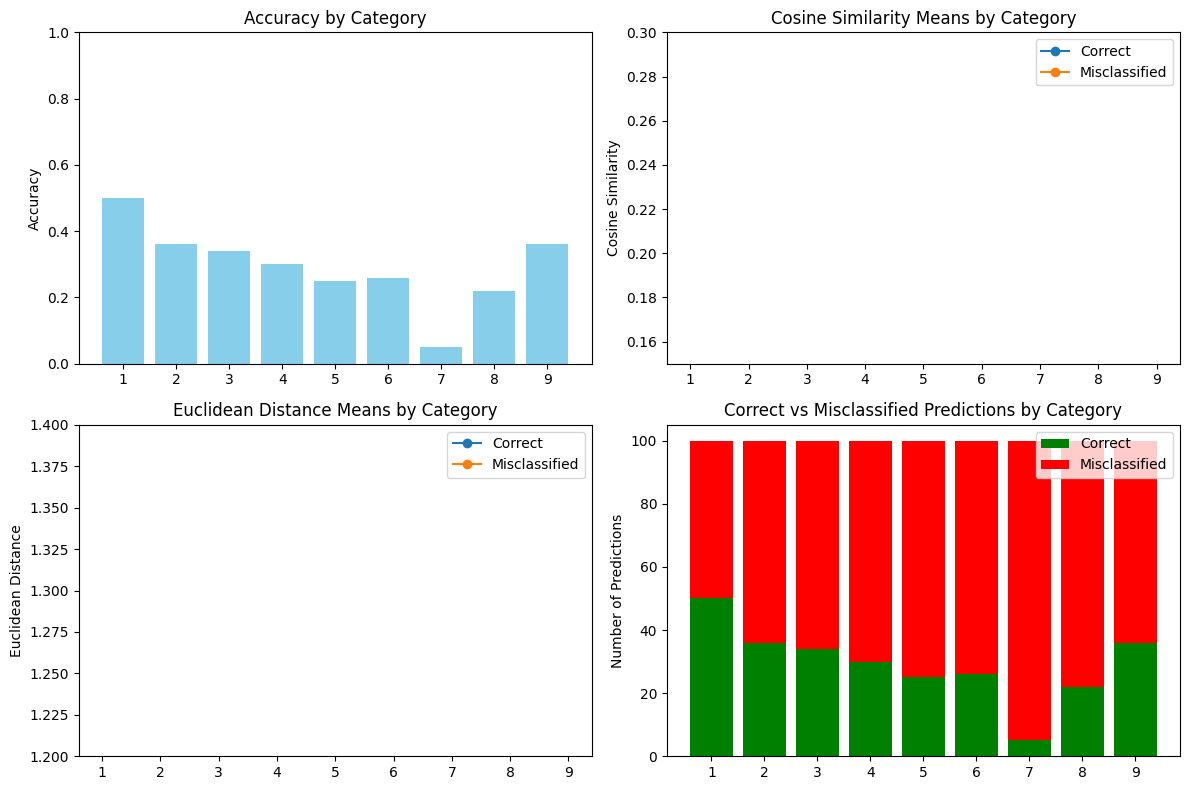

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the necessary statistics from the results_df
accuracy = results_df["Correct"].mean()  # Calculate overall accuracy
total_examples = len(results_df)
correct_predictions = results_df["Correct"].sum()
misclassified_predictions = total_examples - correct_predictions

# Cosine similarity and Euclidean distance for correct and misclassified
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

# Create a new DataFrame for plotting by category (based on true target)
category_stats = results_df.groupby("True Target").agg(
    Correct=("Correct", "sum"),
    Misclassified=("Correct", lambda x: len(x) - x.sum()),
    Accuracy=("Correct", lambda x: x.sum() / len(x)),
    Cosine_Mean_Correct=("Similarity", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Cosine_Mean_Misclassified=("Similarity", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0),
    Euclidean_Mean_Correct=("Euclidean Distance", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Euclidean_Mean_Misclassified=("Euclidean Distance", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0)
).reset_index()

# Extract the numeric part from 'True Target' and convert to integers
category_stats["Numeric_Target"] = category_stats["True Target"].str.extract('(\d+)').astype(int)

# Filter out categories where there are no correct predictions (Accuracy is 0)
category_stats_filtered = category_stats[category_stats["Correct"] > 0]

# Sort by the extracted numeric values
category_stats_filtered = category_stats_filtered.sort_values(by="Numeric_Target")

# Visualization
plt.figure(figsize=(12, 8))

# Accuracy bar chart by category
plt.subplot(2, 2, 1)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Accuracy"], color="skyblue")
plt.title("Accuracy by Category")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Fix y-axis for accuracy
plt.xticks(category_stats_filtered["Numeric_Target"])

# Cosine similarity comparison by category
plt.subplot(2, 2, 2)
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Cosine_Mean_Correct"], marker="o", label="Correct")
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Cosine_Mean_Misclassified"], marker="o", label="Misclassified")
plt.title("Cosine Similarity Means by Category")
plt.ylabel("Cosine Similarity")
plt.ylim(0.15, 0.3)  # Fix y-axis for cosine similarity
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

# Euclidean distance comparison by category
plt.subplot(2, 2, 3)
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Euclidean_Mean_Correct"], marker="o", label="Correct")
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Euclidean_Mean_Misclassified"], marker="o", label="Misclassified")
plt.title("Euclidean Distance Means by Category")
plt.ylabel("Euclidean Distance")
plt.ylim(1.2, 1.4)  # Fix y-axis for Euclidean distance
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

# Correct vs Misclassified Predictions by category
plt.subplot(2, 2, 4)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Correct"], color="green", label="Correct")
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Misclassified"], bottom=category_stats_filtered["Correct"], color="red", label="Misclassified")
plt.title("Correct vs Misclassified Predictions by Category")
plt.ylabel("Number of Predictions")
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

plt.tight_layout()
plt.savefig("results_plots.png")
plt.show()


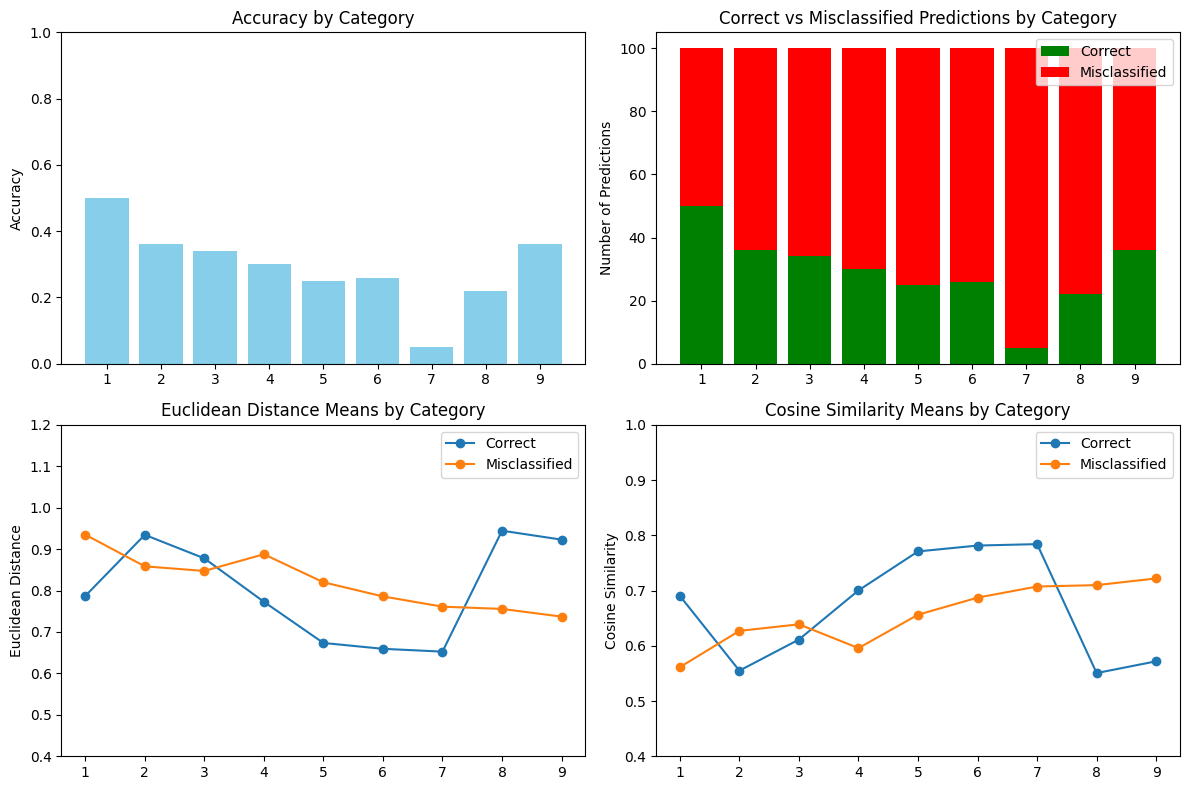

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the necessary statistics from the results_df
accuracy = results_df["Correct"].mean()  # Calculate overall accuracy
total_examples = len(results_df)
correct_predictions = results_df["Correct"].sum()
misclassified_predictions = total_examples - correct_predictions

# Cosine similarity and Euclidean distance for correct and misclassified
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

# Create a new DataFrame for plotting by category (based on true target)
category_stats = results_df.groupby("True Target").agg(
    Correct=("Correct", "sum"),
    Misclassified=("Correct", lambda x: len(x) - x.sum()),
    Accuracy=("Correct", lambda x: x.sum() / len(x)),
    Cosine_Mean_Correct=("Similarity", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Cosine_Mean_Misclassified=("Similarity", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0),
    Euclidean_Mean_Correct=("Euclidean Distance", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Euclidean_Mean_Misclassified=("Euclidean Distance", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0)
).reset_index()

# Extract the numeric part from 'True Target' and convert to integers
category_stats["Numeric_Target"] = category_stats["True Target"].str.extract('(\d+)').astype(int)

# Filter out categories where there are no correct predictions (Accuracy is 0)
category_stats_filtered = category_stats[category_stats["Correct"] > 0]

# Sort by the extracted numeric values
category_stats_filtered = category_stats_filtered.sort_values(by="Numeric_Target")

# Visualization
plt.figure(figsize=(12, 8))

# Accuracy bar chart by category
plt.subplot(2, 2, 1)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Accuracy"], color="skyblue")
plt.title("Accuracy by Category")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Fix y-axis for accuracy
plt.xticks(category_stats_filtered["Numeric_Target"])

# Correct vs Misclassified Predictions by category (now in position 2)
plt.subplot(2, 2, 2)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Correct"], color="green", label="Correct")
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Misclassified"], bottom=category_stats_filtered["Correct"], color="red", label="Misclassified")
plt.title("Correct vs Misclassified Predictions by Category")
plt.ylabel("Number of Predictions")
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

# Euclidean distance comparison by category
plt.subplot(2, 2, 3)
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Euclidean_Mean_Correct"], marker="o", label="Correct")
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Euclidean_Mean_Misclassified"], marker="o", label="Misclassified")
plt.title("Euclidean Distance Means by Category")
plt.ylabel("Euclidean Distance")
plt.ylim(0.4, 1.2)  # Fix y-axis for Euclidean distance
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

# Cosine similarity comparison by category (now in position 4)
plt.subplot(2, 2, 4)
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Cosine_Mean_Correct"], marker="o", label="Correct")
plt.plot(category_stats_filtered["Numeric_Target"], category_stats_filtered["Cosine_Mean_Misclassified"], marker="o", label="Misclassified")
plt.title("Cosine Similarity Means by Category")
plt.ylabel("Cosine Similarity")
plt.ylim(0.4, 1)  # Fix y-axis for cosine similarity
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

plt.tight_layout()
plt.savefig("results_plots.png")
plt.show()



In [ ]:
results_df.to_csv("results_df.csv", sep=";", decimal=",", index=False)

In [15]:
model.eval()

DataParallel(
  (module): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=Tru

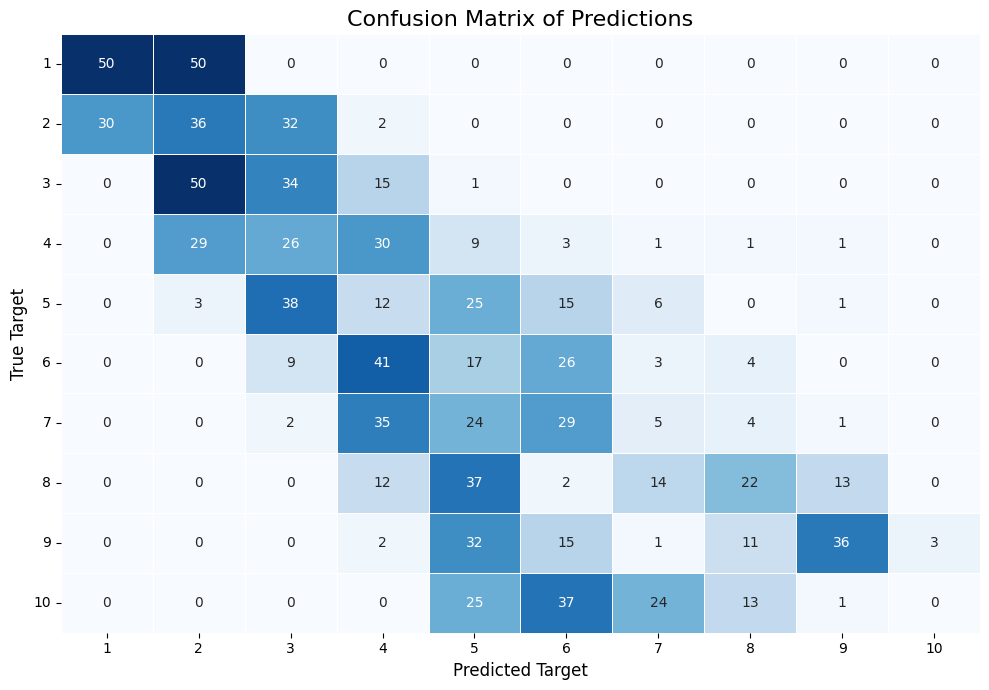

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract numbers from the labels and sort them
sorted_labels = sorted(
    results_df['True Target'].unique(), 
    key=lambda x: int(x.split()[2])  # Extract the number from the string
)

# Create confusion matrix
conf_matrix = confusion_matrix(
    results_df['True Target'], 
    results_df['Predicted Target'], 
    labels=sorted_labels
)

# Extract only the number part of the labels for axis ticks
label_numbers = [label.split()[2] for label in sorted_labels]

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=label_numbers,  # Use numbers only
    yticklabels=label_numbers,  # Use numbers only
    cbar=False,
    linewidths=0.5
)

# Set labels and title
plt.title("Confusion Matrix of Predictions", fontsize=16)
plt.xlabel("Predicted Target", fontsize=12)
plt.yticks(rotation=0)
plt.ylabel("True Target", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


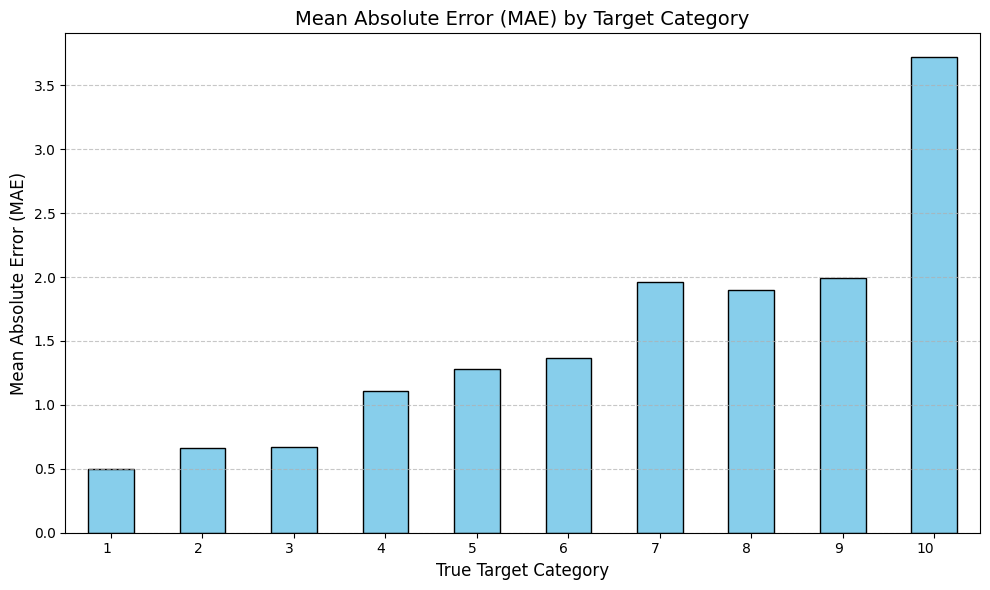

In [9]:
import matplotlib.pyplot as plt

# Extract numerical values from the target columns
results_df["True Target Num"] = results_df["True Target"].str.extract(r'(\d+)').astype(int)
results_df["Predicted Target Num"] = results_df["Predicted Target"].str.extract(r'(\d+)').astype(int)

# Compute absolute error (MAE)
results_df["Absolute Error"] = abs(results_df["True Target Num"] - results_df["Predicted Target Num"])

# Group by target category and calculate mean absolute error
mae_by_target = results_df.groupby("True Target")["Absolute Error"].mean()

# Extract only the numerical part of the target categories for sorting
mae_by_target_sorted = mae_by_target.reindex(sorted(mae_by_target.index, key=lambda x: int(x.split()[2])))

# Extract only the numeric part of the labels for the x-axis
label_numbers = [label.split()[2] for label in mae_by_target_sorted.index]

# Plotting MAE
plt.figure(figsize=(10, 6))
mae_by_target_sorted.plot(kind='bar', color='skyblue', edgecolor='black')

# Modify x-axis labels to show only the numbers
plt.xticks(ticks=range(len(mae_by_target_sorted)), labels=label_numbers, rotation=0, ha="right", fontsize=10)

# Add plot details
plt.title("Mean Absolute Error (MAE) by Target Category", fontsize=14)
plt.xlabel("True Target Category", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


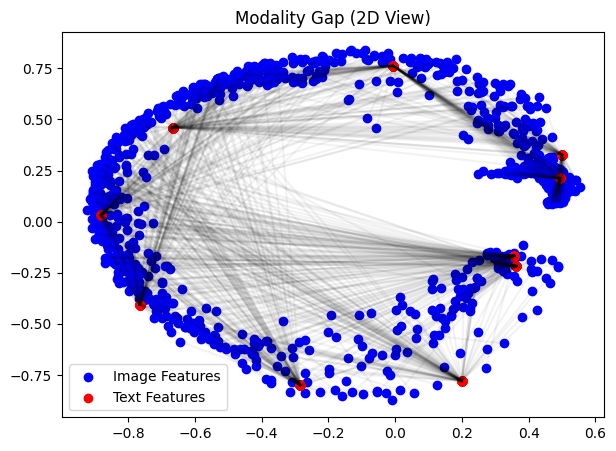

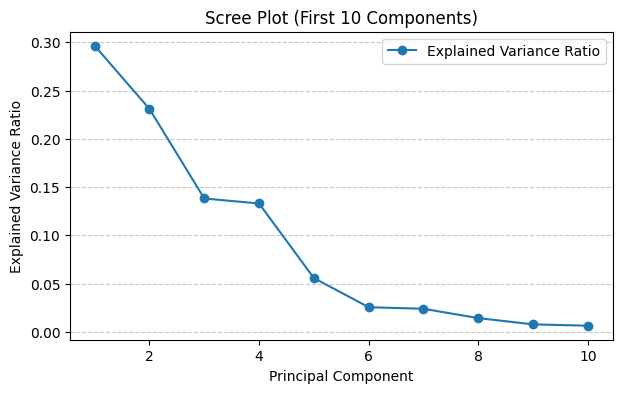

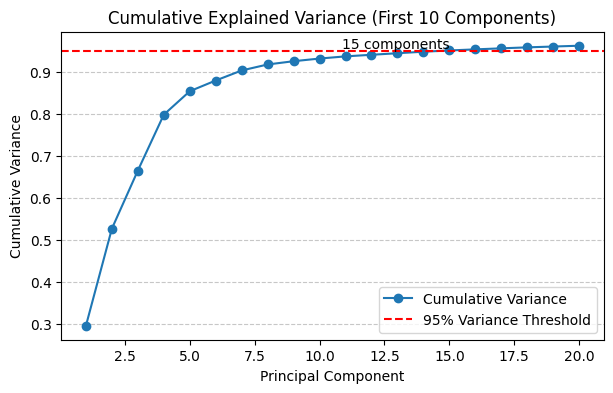

Number of components needed for 95% variance: 15


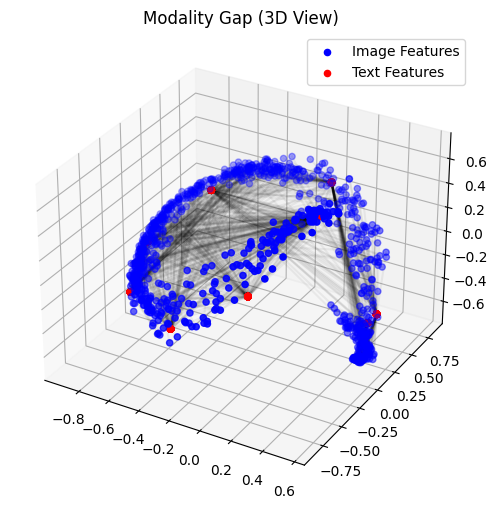

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Normalize features to lie on the surface of a unit hypersphere
def normalize_to_hypersphere(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / norms

# Perform SVD (used for PCA) and calculate explained variance ratio
def perform_svd(X, n_components=10):
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Combine and normalize features
combined_features = np.concatenate([image_features, text_features], axis=0)
normalized_features = normalize_to_hypersphere(combined_features)

# Perform SVD for dimensionality reduction
features_2d, evr, S = perform_svd(normalized_features, n_components=10)

# Plot 2D Visualization with SVD components
plt.figure(figsize=(7, 5))
plt.title("Modality Gap (2D View)")

# Plot the image features in blue
plt.scatter(features_2d[:len(image_features), 0], 
            features_2d[:len(image_features), 1], c='blue', label='Image Features')

# Plot the text features in red
plt.scatter(features_2d[len(image_features):, 0], 
            features_2d[len(image_features):, 1], c='red', label='Text Features')

# Connect paired points between modalities with increased transparency
for i in range(len(image_features)):
    plt.plot([features_2d[i, 0], features_2d[len(image_features) + i, 0]],
             [features_2d[i, 1], features_2d[len(image_features) + i, 1]],
             c='black', alpha=0.05)  # Adjust alpha for more transparency

plt.legend()
plt.show()

# Scree plot for the first 10 components
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(evr[:10]) + 1), evr[:10], marker='o', label='Explained Variance Ratio')
plt.title("Scree Plot (First 10 Components)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Cumulative variance plot
cumulative_variance = np.cumsum(evr[:20])
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title("Cumulative Explained Variance (First 10 Components)")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance")

# Find the number of components required for 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.text(num_components_95, 0.95, f'{num_components_95} components', color='black', 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Number of components needed for 95% variance: {num_components_95}")

# 3D Visualization with SVD components
features_3d, _, _ = perform_svd(normalized_features, n_components=3)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Modality Gap (3D View)")

# Plot image features in blue
ax.scatter(features_3d[:len(image_features), 0], 
           features_3d[:len(image_features), 1], 
           features_3d[:len(image_features), 2], c='blue', label='Image Features')

# Plot text features in red
ax.scatter(features_3d[len(image_features):, 0], 
           features_3d[len(image_features):, 1], 
           features_3d[len(image_features):, 2], c='red', label='Text Features')

# Connect paired points between modalities with increased transparency
for i in range(len(image_features)):
    ax.plot([features_3d[i, 0], features_3d[len(image_features) + i, 0]],
            [features_3d[i, 1], features_3d[len(image_features) + i, 1]],
            [features_3d[i, 2], features_3d[len(image_features) + i, 2]],
            c='black', alpha=0.05)  # Adjust alpha for more transparency
# Rotate the view 
#ax.view_init(elev=20, azim=60)  # Change azim to rotate the plot

ax.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull

# Assuming image_features_proj and text_features are defined, as well as apple_files

data = np.concatenate([image_features, text_features], 0)

# Run t-SNE on data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=3000, random_state=42)
embedding_tsne = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
image_categories = [filename.split('_')[1] for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]
text_categories = [filename.split('_')[1] for filename in test_files]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Manually defined annotation positions (you can modify these)
category_positions = {
    'apples': (9, 9),   # example x, y coordinates
    'butterflies': (11, 11),  # modify these as needed
    'people': (13, 13),
    'dots': (-40, 0),
    'fastcards': (-20, 20)
}

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)
        
        # Calculate centroid of the hull
        centroid = np.mean(current_category_embeddings[hull.vertices], axis=0)
        
        # Check if category has a predefined position
        if category in category_positions:
            annotation_pos = category_positions[category]
            
            # Annotate category with custom position
            plt.annotate(category, 
                         xy=centroid,  # Point to category's centroid
                         xytext=annotation_pos,  # Place text at specified position
                         color='black',
                         fontweight='bold',
                         fontsize=20,  # Increased font size
                         arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)
    
    # Add annotation for text point directly on the point
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(10,10),  # Slight offset to avoid overlapping
                 textcoords='offset points',
                 fontsize=13,
                 color='black',
                 fontweight='bold')

    # Draw an arrow from the text point to the centroid of the image category
    #centroid = np.mean(current_image_embeddings, axis=0)  # Centroid of the image category
    #plt.annotate('', 
    #             xy=(centroid[0], centroid[1]), 
    #             xytext=(text_embedding[0], text_embedding[1]), 
    #             arrowprops=dict(arrowstyle='->', color=image_colors[idx], lw=1))

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.savefig('t-SNE_visualization_with_category_annotations.png')
plt.show()
